# 0 Preparation

## 0.1 Imports
Run this cell and skip to next one

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import cv2

from keras_tuner.tuners import Hyperband
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Reshape, Input, InputLayer, Dropout
from keras.callbacks import Callback
from keras import callbacks
from tensorflow.keras.optimizers import SGD, Adam
from IPython.display import clear_output

## 0.2 Defining functions and classes
Run this cell and skip to next one

In [16]:
def visualize(img,encoder,decoder, width=2):
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.figure(figsize=(8, 3))
    plt.subplot(1,3,1)
    plt.title("Original")
    low, high = np.min(img), np.max(img)
    temp = 255.0 * (img - low) / (high - low)
    plt.imshow(temp.astype('uint8'), cmap='gray')

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//width,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    low, high = np.min(reco), np.max(reco)
    temp = 255.0 * (reco - low) / (high - low)
    plt.imshow(temp.astype('uint8'), cmap='gray')
    plt.show()


def print_image_versions(eg):
    example = dict()
    for i in range(9):
        example[i] = pickle.load(open(basepath + "data"+str(i)+".pickle", 'rb'), encoding='latin1')["x_train"].transpose(0, 2, 3, 1)

    plt.rcParams['figure.figsize'] = (15.0, 15.0)
    n = [0, 2, 3, 7, 8]
    m = ['Normal', 'RGB + /255 + Mean', 'RGB + /255 + Mean + STD', 'LHE + /255 + Mean', 'LHE + /255 + Mean + STD']
    k = 5
    ii = 0
    for i in n:
        plt.subplot(2, 4, k-1)
        if i == 7 or i == 8:
            plt.imshow(example[i][eg], cmap='gray')
        else:
            plt.imshow(example[i][eg])
        plt.xlabel(m[ii], fontsize=10)
        plt.ylabel("data"+str(i)+".pickle", fontsize=12)
        plt.xticks([])
        plt.yticks([])
        k += 1
        ii += 1


def print_dist():
    temp = list()
    for idx in range(len(data["y_train"])):
        index = data["y_train"][idx].tolist().index(1)
        print(index)
        temp.append(data["labels"][index])

    from collections import Counter
    counter = Counter(temp)
    for key, value in counter.items():
        print("sign: ", key, ", total: ", value)


class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_accuracies.append(logs.get('val_accuracy'))
        self.i += 1

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_figheight(4)
        fig.set_figwidth(16)
        fig.suptitle('Accuracy & Learning Rate')

        ax1.set_title('Model loss')
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss Rate")
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend(loc="upper right")

        if self.accuracies:
            ax2.set_title('Model accuracy')
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("Accuracy")
            ax2.plot(self.x, self.accuracies, label="accuracy")
            ax2.plot(self.x, self.val_accuracies, label="val_accuracy")
            ax2.legend(loc="lower right")

        plt.show();

plot_losses = PlotLosses()


def plot_image(image):
    low, high = np.min(image), np.max(image)
    img = 255.0 * (image - low) / (high - low)
    plt.imshow(img.astype('uint8'), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()


# 1 Prepare Data

## 1.1 Load Dataset
- Load data2.pickle
- Covert labels to numeric values (Models cannot process string labels)
- re-arrange dataset matrix (RGB channel should best last)

In [4]:
#----------------------------------------
# DEFINE PATH TO DATASET FOLDER HERE
basepath = "data/"
#----------------------------------------

# Opening file for reading in binary mode
with open(basepath + "data2.pickle", 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)
data['y_test'] = to_categorical(data['y_test'], num_classes=43)

# Making RGB channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

## 1.2 Show Dataset Information
- Value range of image values
- Median value of image values
- Shape of image datasets
- Shape of label datasets
- Amount of lables

<em>Optional methods (disabled by default):</em>
- Display N images
- Visualize image with different kinds of pre-processing
- Show category distribution

In [5]:
print("Highest value: ", max([np.amax(data['x_train']), np.amax(data['x_validation']), np.amax(data['x_test'])]), "Lowest value: ", min([np.amin(data['x_train']), np.amin(data['x_validation']), np.amin(data['x_test'])]))
print("Median: ", np.median(np.concatenate([data['x_train'], data['x_test'], data['x_validation']], axis=0)))
print()

print("x_train", data['x_train'].shape)
print("x_validation", data['x_validation'].shape)
print("x_test", data['x_test'].shape)
print()

print("y_train", data['y_train'].shape)
print("y_validation", data['y_validation'].shape)
print("y_test", data['y_test'].shape)
print()

print("Categories: ", len(data["labels"]))

# Show n amounts of images
#for i in range(5):
#    plot_image(data['x_train'][i])

# Visualize  the different pre processing types for an image
# print_image_versions(1)

# Show the distribution of categories for the dataset
# print_dist()

Highest value:  0.8779018 Lowest value:  -0.37349513
Median:  -0.071020454

x_train (86989, 32, 32, 3)
x_validation (4410, 32, 32, 3)
x_test (12630, 32, 32, 3)

y_train (86989, 43)
y_validation (4410, 43)
y_test (12630, 43)

Categories:  43


## 1.3 Reshaping Data for Input Layer
Converting image matrix (32, 32, 3) into one dimensional vector (3072)

In [5]:
nRows,nCols,nDims = x_train = data["x_train"].shape[1:]
data["x_train_flat"] = data["x_train"].reshape(data["x_train"].shape[0], nRows * nCols * nDims)
data["x_validation_flat"] = data["x_validation"].reshape(data["x_validation"].shape[0], nRows * nCols * nDims)
data["x_test_flat"] = data["x_test"].reshape(data["x_test"].shape[0], nRows * nCols * nDims)

print("original shape:", data["x_train"].shape[1:])
print("flattened shape:", data["x_train_flat"].shape[1])

original shape: (32, 32, 3)
flattened shape: 3072


# 2 Multi-Layer-Perceptron:



## 2.1  MLP Model Definition

Two different models which scored best on evaluation accuracy


In [7]:
modelMLP1 = Sequential(name="Multi-Layer-Perceptron-Simple")
modelMLP1.add(Dense(768, activation='sigmoid', input_dim=3072, name="Input-Layer"))
modelMLP1.add(Dense(43, activation='sigmoid', name="Output-Layer"))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
modelMLP1.compile(loss='categorical_crossentropy',
                   optimizer=sgd,
                   metrics=['accuracy'])

modelMLP1.summary()

Model: "Multi-Layer-Perceptron-Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 768)               2360064   
                                                                 
 Output-Layer (Dense)        (None, 43)                33067     
                                                                 
Total params: 2,393,131
Trainable params: 2,393,131
Non-trainable params: 0
_________________________________________________________________


In [12]:
modelMLP2 = Sequential(name="Multi-Layer-Perceptron-Deep")
modelMLP2.add(Dense(768, activation='relu', input_dim=3072, name="Input-Layer"))
modelMLP2.add(Dropout(0.2, name="Dropout-1"))
modelMLP2.add(Dense(384, activation='relu', name="Hidden-Layer"))
modelMLP2.add(Dropout(0.2, name="Dropout-2"))
modelMLP2.add(Dense(43, activation='softmax', name="Output-Layer"))

sgd = SGD(learning_rate=0.005, decay=1e-6, momentum=0.9, nesterov=True)
modelMLP2.compile(loss='categorical_crossentropy',
                 optimizer=sgd,
                 metrics=['accuracy'])

modelMLP2.summary()

Model: "Multi-Layer-Perceptron-Deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 768)               2360064   
                                                                 
 Dropout-1 (Dropout)         (None, 768)               0         
                                                                 
 Hidden-Layer (Dense)        (None, 384)               295296    
                                                                 
 Dropout-2 (Dropout)         (None, 384)               0         
                                                                 
 Output-Layer (Dense)        (None, 43)                16555     
                                                                 
Total params: 2,671,915
Trainable params: 2,671,915
Non-trainable params: 0
_________________________________________________________________


## 2.2 MLP Model Training

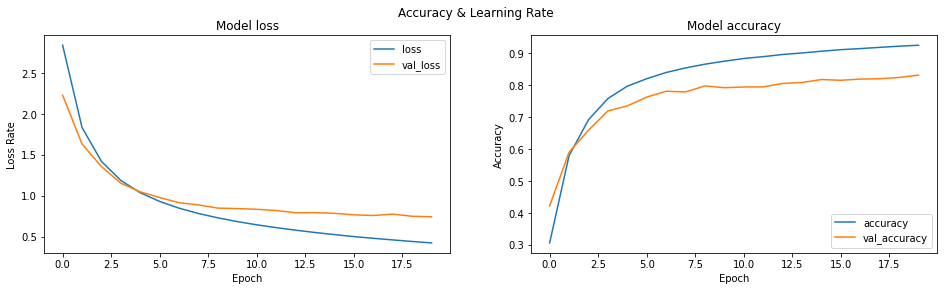

In [10]:
hist_modelMLP1=modelMLP1.fit(data["x_train_flat"], data["y_train"],
                            shuffle=True,
                            epochs=20,
                            batch_size=100,
                            verbose=0,
                            validation_data=(data["x_validation_flat"], data["y_validation"]),
                            callbacks=[plot_losses])

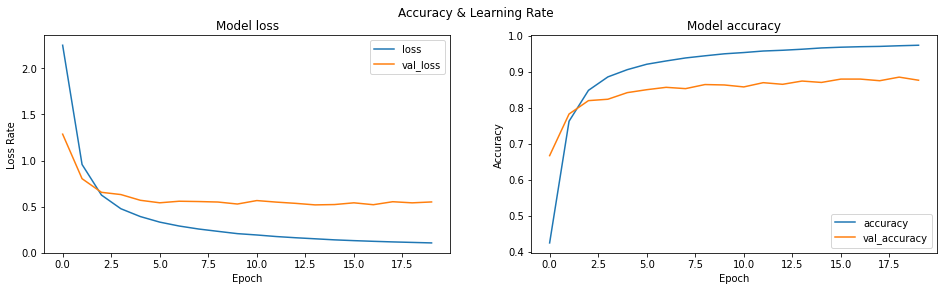

In [13]:
hist_modelMLP2=modelMLP2.fit(data["x_train_flat"], data["y_train"],
                             shuffle=True,
                             epochs=20,
                             batch_size=100,
                             verbose=0,
                             validation_data=(data["x_validation_flat"], data["y_validation"]),
                             callbacks=[plot_losses])

## 2.3 MLP Model Evaluation

In [14]:
score_ModelMLP1 = modelMLP1.evaluate(data["x_test_flat"], data["y_test"], batch_size=1) #erster Wert loss, zweiter Wert accuracy hier 95%
print("Loss: ",score_ModelMLP1[0])
print("Accuracy: ","{0:.2%}".format(score_ModelMLP1[1]))

12630/12630 [==============================] - 28s 2ms/step - loss: 0.7531 - accuracy: 0.8340
Loss:  0.7530696392059326
Accuracy:  83.40%


In [15]:
score_ModelMLP2 = modelMLP2.evaluate(data["x_test_flat"], data["y_test"], batch_size=1) #erster Wert loss, zweiter Wert accuracy hier 95%
print("Loss: ",score_ModelMLP2[0])
print("Accuracy: ","{0:.2%}".format(score_ModelMLP2[1]))

12630/12630 [==============================] - 29s 2ms/step - loss: 0.6770 - accuracy: 0.8691
Loss:  0.6769688725471497
Accuracy:  86.91%


# 3 Convolutional Neural Network

## 3.1 CNN Model Definition

Defining variable model Parameters:
- 

In [18]:
def build_model(hp):
    modelCNN = Sequential(name="CNN-3-Convs")
    modelCNN.add(Conv2D(filters=hp.Choice('conv_1_filter', values=[48, 64]), kernel_size = (4,4), padding = "Same", activation = "relu", input_shape = (32,32,3)))
    modelCNN.add(MaxPool2D(pool_size = (2,2)))
    modelCNN.add(Conv2D(filters=32, kernel_size = (4,4), padding = "Same", activation = "relu" ))
    modelCNN.add(MaxPool2D(pool_size = (2,2)))
    modelCNN.add(Conv2D(filters=16, kernel_size = (4,4), padding = "Same", activation = "relu" ))
    modelCNN.add(MaxPool2D(pool_size = (2,2)))
    modelCNN.add(Flatten())
    modelCNN.add(Dense(units=hp.Int('dense_1_units', min_value=256, max_value=512, step=128, default=512),
                       activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
    modelCNN.add(Dropout(0.5))
    modelCNN.add(Dense(units = 43, activation = "softmax"))

    modelCNN.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']), loss = "categorical_crossentropy", metrics = ["accuracy"])
    return modelCNN

## 3.2 Determining the best Hyper Parameter with Keras Tuner Hyperband

In [19]:
tuner = Hyperband(
    build_model,
    max_epochs=15,
    objective='val_accuracy',
    executions_per_trial=1,
)
# search best parameter
tuner.search(data["x_train"], data["y_train"],
              epochs=10,
              validation_data=(data["x_validation"], data["y_validation"])
              )

tuner.results_summary()

Trial 30 Complete [00h 03m 14s]
val_accuracy: 0.9310657382011414

Best val_accuracy So Far: 0.9560090899467468
Total elapsed time: 00h 39m 27s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 64
dense_1_units: 256
dense_activation: tanh
optimizer: rmsprop
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9560090899467468
Trial summary
Hyperparameters:
conv_1_filter: 48
dense_1_units: 256
dense_activation: tanh
optimizer: adam
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9405895471572876
Trial summary
Hyperparameters:
conv_1_filter: 64
dense_1_units: 256
dense_activation: relu
optimizer: rmsprop
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: fcbfe3143290a08769257dc56a9b4a44
Score: 0.9383220076560974
Trial summary
Hyperparameters:
c

In [20]:
best_CNN_Models = tuner.get_best_models(num_models=5)
scores_CNN_Models = []

for idx, model in enumerate(best_CNN_Models):
  score = model.evaluate(data["x_test"], data["y_test"], batch_size=1, verbose=0)
  scores_CNN_Models.append(score)
  print(idx)
  print("Loss: ",score[0])
  print("Accuracy: ","{0:.2%}".format(score[1]))
  print()


0
Loss:  0.22326405346393585
Accuracy:  94.20%

1
Loss:  0.3680344820022583
Accuracy:  92.86%

2
Loss:  0.744378924369812
Accuracy:  91.54%

3
Loss:  0.4325833320617676
Accuracy:  91.31%

4
Loss:  0.3506070077419281
Accuracy:  92.49%



3.2 Re-defining best performing CNN Model

In [42]:
modelCNN = Sequential(name="Best-CNN-Model")
modelCNN.add(Conv2D(filters = 64, kernel_size = (4,4), padding = "Same", activation = "relu", input_shape = (32,32,3)))
modelCNN.add(MaxPool2D(pool_size = (2,2)))
modelCNN.add(Conv2D(filters = 32, kernel_size = (4,4), padding = "Same", activation = "relu" ))
modelCNN.add(MaxPool2D(pool_size = (2,2)))
modelCNN.add(Conv2D(filters = 16, kernel_size = (4,4), padding = "Same", activation = "relu" ))
modelCNN.add(MaxPool2D(pool_size = (2,2)))
modelCNN.add(Flatten())
modelCNN.add(Dense(units = 256, activation = "tanh"))
modelCNN.add(Dropout(0.5))
modelCNN.add(Dense(units = 43, activation = "softmax"))

modelCNN.compile(optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"])
modelCNN.summary()

Model: "Best-CNN-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 32)        32800     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 8, 8, 16)          8208      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 4, 4, 16)      

## 3.3 CNN Model Training

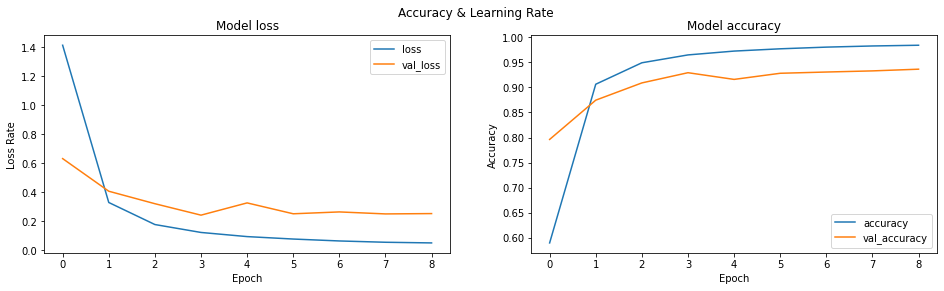

870/870 [==============================] - 6s 7ms/step - loss: 0.0504 - accuracy: 0.9844 - val_loss: 0.2530 - val_accuracy: 0.9365


In [43]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)

hist_modelCNN = modelCNN.fit(
    data['x_train'], data['y_train'],
    shuffle=True,
    batch_size=100,
    epochs = 18,
    validation_data = (data['x_validation'], data['y_validation']),
    callbacks=[earlystopping, plot_losses],
)

## 3.4 CNN Model Evaluation

In [44]:
score_ModelCNN = modelCNN.evaluate(data["x_test"], data["y_test"], batch_size=1)
print("Loss: ", score_ModelCNN[0])
print("Accuracy: ","{0:.2%}".format(score_ModelCNN[1]))

12630/12630 [==============================] - 38s 3ms/step - loss: 0.2874 - accuracy: 0.9219
Loss:  0.2873852849006653
Accuracy:  92.19%


# 4 Autoencoder

## 4.1 AE Model Definition

In [48]:
# Dimension of input (32, 32, 3)
input_shape = data["x_train"].shape[1:]
# Defining the dimension of encoded images
enc_dim = 32

modelEncoderSmall = Sequential(name="Encoder-small")
modelEncoderSmall.add(InputLayer(input_shape))
modelEncoderSmall.add(Flatten())
modelEncoderSmall.add(Dense(enc_dim))

modelDecoderSmall = Sequential(name="Decoder-small")
modelDecoderSmall.add(InputLayer((enc_dim,)))
modelDecoderSmall.add(Dense(np.prod(input_shape)))
modelDecoderSmall.add(Reshape(input_shape))

inpSmall = Input(input_shape, name="Input-Layer-AE-small")
encodingSmall = modelEncoderSmall(inpSmall)
decodingSmall = modelDecoderSmall(encodingSmall)

modelAutoencoderSmall = Model(inpSmall,decodingSmall, name="Auto-Encoder-small")
modelAutoencoderSmall.compile(optimizer='adamax', loss='mse')

modelAutoencoderSmall.summary()

Model: "Auto-Encoder-small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer-AE-small (Input  [(None, 32, 32, 3)]      0         
 Layer)                                                          
                                                                 
 Encoder-small (Sequential)  (None, 32)                98336     
                                                                 
 Decoder-small (Sequential)  (None, 32, 32, 3)         101376    
                                                                 
Total params: 199,712
Trainable params: 199,712
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Dimension of input (32, 32, 3)
input_shape = data["x_train"].shape[1:]
# Defining the dimension of encoded images
enc_dim = 192 #384

modelEncoderLarge = Sequential(name="Encoder-large")
modelEncoderLarge.add(InputLayer(input_shape))
modelEncoderLarge.add(Flatten())
modelEncoderLarge.add(Dense(enc_dim))

modelDecoderLarge = Sequential(name="Decoder-large")
modelDecoderLarge.add(InputLayer((enc_dim,)))
modelDecoderLarge.add(Dense(np.prod(input_shape)))
modelDecoderLarge.add(Reshape(input_shape))

inpLarge = Input(input_shape, name="Input-Layer-AE-large")
encodingLarge = modelEncoderLarge(inpLarge)
decodingLarge = modelDecoderLarge(encodingLarge)

modelAutoencoderLarge = Model(inpLarge,decodingLarge, name="Auto-Encoder-large")
modelAutoencoderLarge.compile(optimizer='adamax', loss='mse')

modelAutoencoderLarge.summary()

Model: "Auto-Encoder-large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer-AE-large (Input  [(None, 32, 32, 3)]      0         
 Layer)                                                          
                                                                 
 Encoder-large (Sequential)  (None, 192)               590016    
                                                                 
 Decoder-large (Sequential)  (None, 32, 32, 3)         592896    
                                                                 
Total params: 1,182,912
Trainable params: 1,182,912
Non-trainable params: 0
_________________________________________________________________


## 4.2 AE Model Training

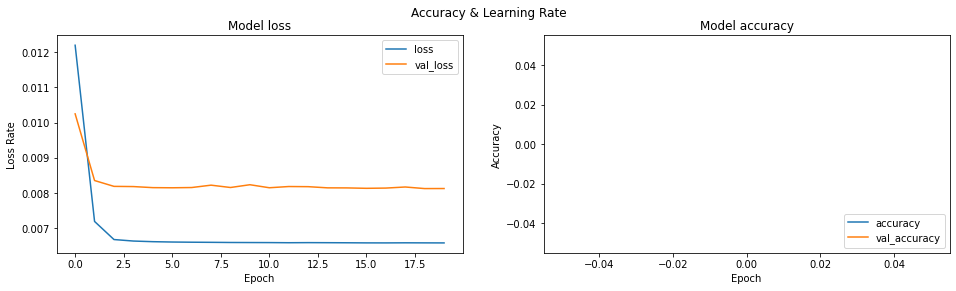

In [49]:
history_modelAutoencoderSmall = modelAutoencoderSmall.fit(x=data["x_train"], y=data["x_train"],
                          epochs=20,
                          verbose=0,
                          batch_size=100,
                          shuffle=True,
                          validation_data=[data["x_validation"], data["x_validation"]],
                          callbacks=[plot_losses]
                          )

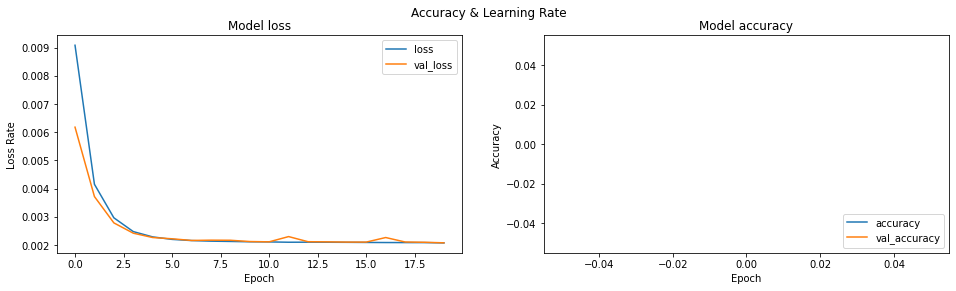

In [26]:
history_modelAutoencoderLarge = modelAutoencoderLarge.fit(x=data["x_train"], y=data["x_train"],
                                                          epochs=20,
                                                          verbose=0,
                                                          batch_size=100,
                                                          shuffle=True,
                                                          validation_data=[data["x_validation"], data["x_validation"]],
                                                          callbacks=[plot_losses]
                                                          )

## 4.3 AE Model Evaluation

In [50]:
score_modelAutoencoderSmall = modelAutoencoderSmall.evaluate(data["x_test"], data["x_test"], batch_size=1)
print("Loss Rate: ", score_modelAutoencoderSmall)

12630/12630 [==============================] - 21s 2ms/step - loss: 0.0093
Loss Rate:  0.00933261401951313


In [27]:
score_modelAutoencoderLarge = modelAutoencoderLarge.evaluate(data["x_test"], data["x_test"], batch_size=1)
print("Loss Rate: ", score_modelAutoencoderLarge)

12630/12630 [==============================] - 20s 2ms/step - loss: 0.0028
Loss Rate:  0.0028308406472206116


## 4.4 AE Model generate Encoded Images

In [51]:
data["x_train_encoded_small"] = modelEncoderSmall.predict(data["x_train"])
data["x_validation_encoded_small"] = modelEncoderSmall.predict(data["x_validation"])
data["x_test_encoded_small"] = modelEncoderSmall.predict(data["x_test"])

data["x_train_encoded_large"] = modelEncoderLarge.predict(data["x_train"])
data["x_validation_encoded_large"] = modelEncoderLarge.predict(data["x_validation"])
data["x_test_encoded_large"] = modelEncoderLarge.predict(data["x_test"])

# Show example image
# plt.imshow(data["x_train_encoded"][1].reshape([data["x_train_encoded"].shape[-1]//2,-1]))

## 4.4 Show Encoded Examples

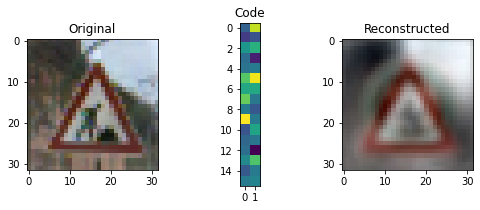

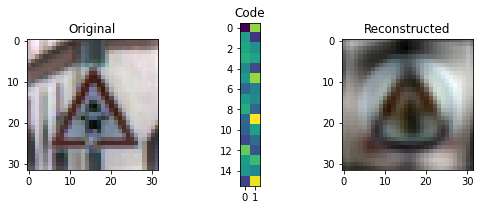

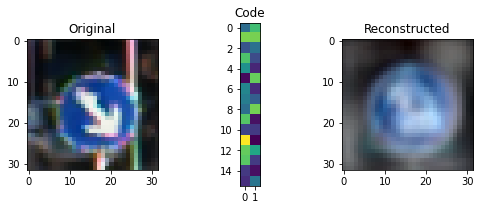

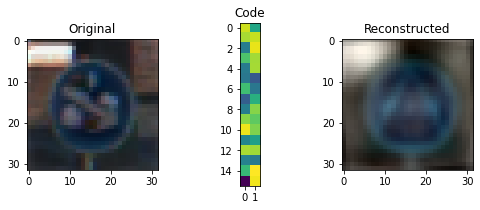

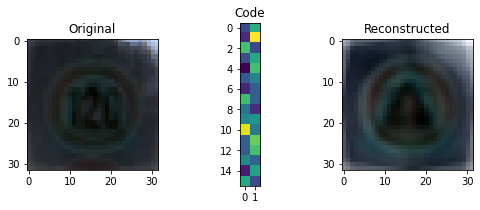

In [ ]:
for i in range(5): #[1, 2, 6, 9]: [16, 22, 26, 29]
    img = data["x_test"][i]
    visualize(img, modelEncoderSmall, modelDecoderSmall)

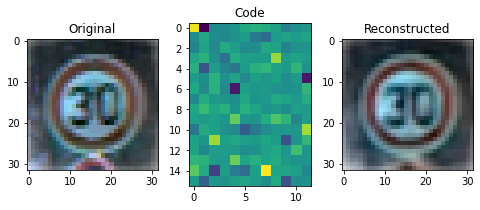

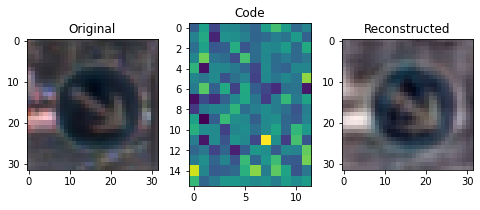

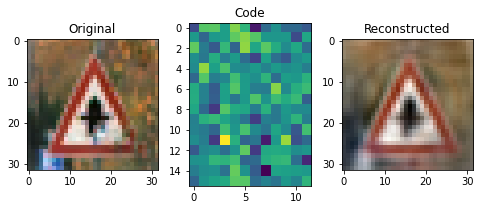

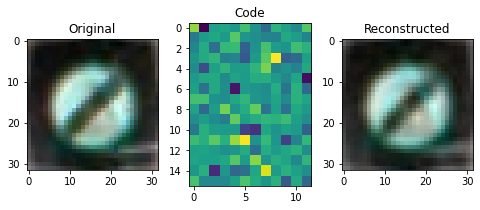

In [28]:
for i in [16, 22, 26, 29]: #[1, 2, 6, 9]: #
    img = data["x_test"][i]
    visualize(img, modelEncoderLarge, modelDecoderLarge, width=12)

# 5 MLP Model with encoded images

## 5.1 MLP-Encoded Model Definition

In [52]:
modelMLPAESmall = Sequential(name="Multi-Layer-Perceptron-Encoded-Small")
modelMLPAESmall.add(Dense(30, activation='sigmoid', input_dim=32, name="Input-Layer-Encoded-Small"))
modelMLPAESmall.add(Dense(43, activation='sigmoid', name="Output-Layer-Encoded-Small"))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
modelMLPAESmall.compile(loss='categorical_crossentropy',
                 optimizer=sgd,
                 metrics=['accuracy'])
modelMLPAESmall.summary()

Model: "Multi-Layer-Perceptron-Encoded-Small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer-Encoded-Small (  (None, 30)               990       
 Dense)                                                          
                                                                 
 Output-Layer-Encoded-Small   (None, 43)               1333      
 (Dense)                                                         
                                                                 
Total params: 2,323
Trainable params: 2,323
Non-trainable params: 0
_________________________________________________________________


In [29]:
modelMLPAELarge = Sequential(name="Multi-Layer-Perceptron-Encoded-Large")
modelMLPAELarge.add(Dense(192, activation='sigmoid', input_dim=192, name="Input-Layer-Encoded-Large"))
modelMLPAELarge.add(Dense(43, activation='sigmoid', name="Output-Layer-Encoded-Large"))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
modelMLPAELarge.compile(loss='categorical_crossentropy',
                        optimizer=sgd,
                        metrics=['accuracy'])
modelMLPAELarge.summary()

Model: "Multi-Layer-Perceptron-Encoded-Large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer-Encoded-Large (  (None, 192)              37056     
 Dense)                                                          
                                                                 
 Output-Layer-Encoded-Large   (None, 43)               8299      
 (Dense)                                                         
                                                                 
Total params: 45,355
Trainable params: 45,355
Non-trainable params: 0
_________________________________________________________________


## 5.1 MLP-Encoded Model Training

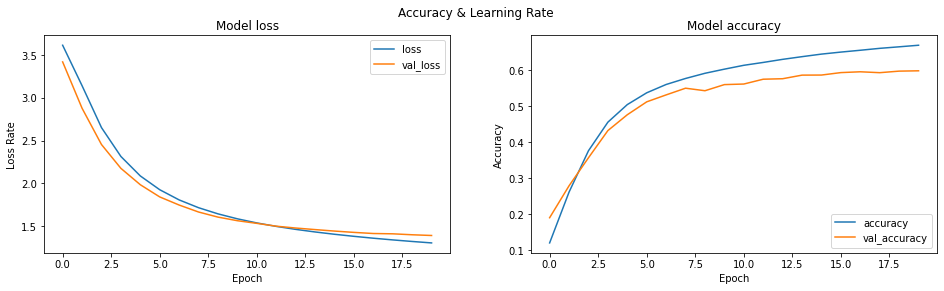

In [53]:
hist_modelMLPAESmall=modelMLPAESmall.fit(data["x_train_encoded_small"], data["y_train"],
                           shuffle=True,
                           epochs=20,
                           batch_size=100,
                           verbose=0,
                           validation_data=(data["x_validation_encoded_small"], data["y_validation"]),
                           callbacks=[plot_losses])

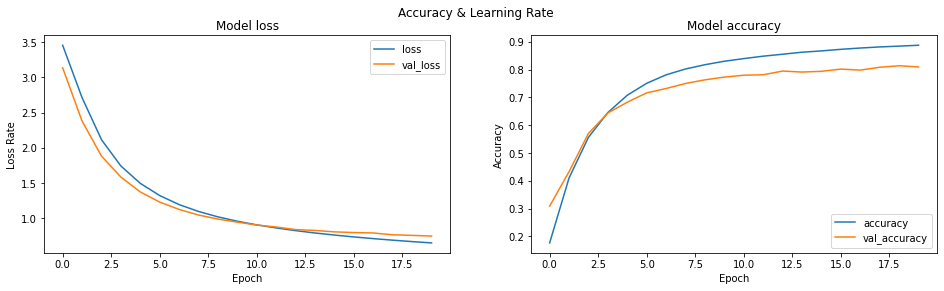

In [33]:
hist_modelMLPAELarge=modelMLPAELarge.fit(data["x_train_encoded_large"], data["y_train"],
                                    shuffle=True,
                                    epochs=20,
                                    batch_size=100,
                                    verbose=0,
                                    validation_data=(data["x_validation_encoded_large"], data["y_validation"]),
                                    callbacks=[plot_losses])

## 5.1 MLP-Encoded Model Evaluation

In [54]:
score_modelMLPAESmall = modelMLPAESmall.evaluate(data["x_test_encoded_small"], data["y_test"], batch_size=1) #erster Wert loss, zweiter Wert accuracy hier 95%
print("Loss: ", score_modelMLPAESmall[0])
print("Accuracy: ","{0:.2%}".format(score_modelMLPAESmall[1]))

12630/12630 [==============================] - 34s 3ms/step - loss: 1.4310 - accuracy: 0.5824
Loss:  1.4310216903686523
Accuracy:  58.24%


In [37]:
score_modelMLPAELarge = modelMLPAELarge.evaluate(data["x_test_encoded_large"], data["y_test"], batch_size=1) #erster Wert loss, zweiter Wert accuracy hier 95%
print("Loss: ", score_modelMLPAELarge[0])
print("Accuracy: ","{0:.2%}".format(score_modelMLPAELarge[1]))

Loss:  0.7690361738204956
Accuracy:  81.94%


# 6 Predict custom Image

In this section the best model is used to classify a selfmade 30km/h speed limit sign I took with my phone. The orginal picture  is manually segmentend and converted into the extpected shape.

## 6.1 Prepare input Image

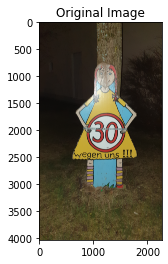

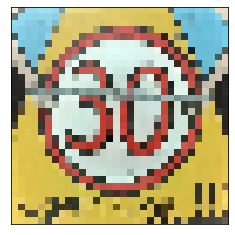

In [ ]:
# Show Original Image
plt.title("Original Image")
plt.imshow(cv2.cvtColor(cv2.imread("traffic_sign_custom.jpg"), cv2.COLOR_BGR2RGB))
plt.show()

# Load cropped image as RGB
custom_image = cv2.cvtColor(cv2.imread("traffic_sign_custom_cropped.jpg"), cv2.COLOR_BGR2RGB)
# Resize to 32 x 32
custom_image = cv2.resize(custom_image, (32, 32))
# Normalize values between 0 and 1
custom_image = custom_image.astype("float32") / 255.0

# To match dataset, image mean image value must be subtracted from image
for_mean = pickle.load(open(basepath + "data0.pickle", 'rb'), encoding='latin1')["x_train"].transpose(0, 2, 3, 1)
for_mean = for_mean.astype(np.float32) / 255.0
mean_image = np.mean(for_mean, axis=0)
custom_image -= mean_image
plot_image(custom_image)

# Expand dim for model prediction
custom_image = np.expand_dims(custom_image, axis=0)
custom_image_cnn = custom_image
custom_image_mlp = custom_image.reshape(custom_image.shape[0], 3072)

## 6.2 Show Model Prediction

In [ ]:
prediction = modelCNN.predict(custom_image_cnn)
df = pd.DataFrame(prediction.T, columns=["probability"]).sort_values('probability', ascending=False)
df["Label"] = data["labels"]
df

,probability,Label
1,8.764261e-01,Speed limit (20km/h)
21,1.231562e-01,Speed limit (30km/h)
12,3.794443e-04,Speed limit (50km/h)
28,8.725908e-06,Speed limit (60km/h)
3,6.158067e-06,Speed limit (70km/h)
36,5.971587e-06,Speed limit (80km/h)
32,5.186167e-06,End of speed limit (80km/h)
13,4.503895e-06,Speed limit (100km/h)
26,2.791033e-06,Speed limit (120km/h)
25,1.723715e-06,No passing
